# Amazon Rainforest
### Resilience Assessment // Seminar Earth System Science in the Anthropocene

In [1]:
# Import Libraries
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import odeint
import numpy as np

## The Model

Levin's widely accepted vegetation model

$$\begin{equation}
\frac{dC}{dt} = F(C) =
\begin{cases} 
    r(1 − C)C − x C & \text{if } C > C_{crit} \\
    −x C & \text{if } C < C_{crit}
\end{cases}
\end{equation}$$

for $C$ forest cover, $r$ saturation rate, $x$ death rate ($r > x > 0$).

### Constants and Parameters

In [2]:
# Define Constants
c0 = 0.81 # Current Amazon rainforest tree coverage from literature
saturation_rate = 0.6 # made-up growth rate
die_rate = 0.05 # made-up forest death rate (chosen in a way that C_f (forest state) (see below) > c0)

In [3]:
# Define critical value c_crit as a linear function from aridity as in paper
def c_crit(aridity):
    c_crit_value = 0.7 * aridity - 0.1
    return c_crit_value

In [4]:
aridities = list(np.linspace(0.14,1.57,100)) # c_crit in [0,1]

### Model steps

In [5]:
def next_step(cover, aridity, die_rate=die_rate, saturation_rate=saturation_rate):
  if cover <= c_crit(aridity):
    dcdt = -die_rate * cover
  else:
    dcdt = saturation_rate * (1 - cover) * cover - die_rate * cover
  return cover + dcdt

In [6]:
def k_steps(cover, aridity, k, die_rate=die_rate, saturation_rate=saturation_rate):
  ret = [cover]
  while len(ret) < k:
    ret.append(next_step(ret[-1], aridity, die_rate, saturation_rate))
  return ret

### Run Model

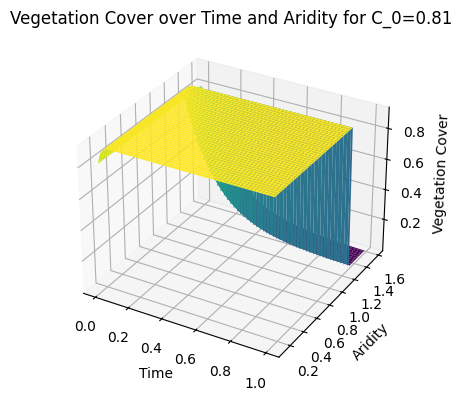

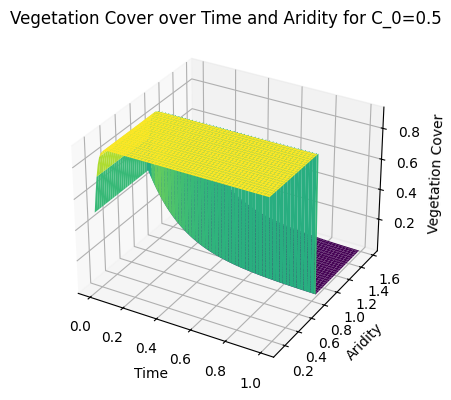

In [7]:
def plot_cover_time_aridities(time_steps, aridities, c0):
  fig = plt.figure(figsize=(25,4))
  ax = fig.add_subplot(111, projection='3d')
  X, Y = np.meshgrid(np.linspace(0,1,time_steps), aridities)
  Z = np.array([k_steps(c0, a, time_steps) for a in aridities])

  ax.plot_surface(X, Y, Z, cmap='viridis')
  ax.set_xlabel('Time')
  ax.set_ylabel('Aridity')
  ax.set_zlabel('Vegetation Cover')
  ax.set_title(f'Vegetation Cover over Time and Aridity for C_0={c0}')
  
  plt.tight_layout()
  plt.show()

plot_cover_time_aridities(100, aridities, c0)
plot_cover_time_aridities(100, aridities, 0.5)

<br>

# Local Stability Measures

## Linear Stability Analysis

Examining the stability of an equilibrium point by linearizing the system around that point.

**Equilibria** (calculated via $F(C) = 0$):

- if $C < C_{crit}$: $C_s = 0$

- if $C > C_{crit}$: $C_s = 0$ and $C_f = 1 - \frac{x}{r}$

In [8]:
# Equilibrium forest state
def forest_state(saturation_rate=saturation_rate, die_rate=die_rate):
    forest_state = 1 - die_rate / saturation_rate
    return forest_state

In [9]:
# Print forest state for intial death and saturation rate
forest_state()

0.9166666666666666

**Linear stability** at equilibria (calculated via $F'(C^*) = 0$):
$$\begin{equation}
F'(C) =
\begin{cases} 
    r(1-2C)-x & \text{if } C > C_{crit} \\
    −x & \text{if } C < C_{crit}
\end{cases}
\end{equation}$$

- $C_s = 0\,\,(< C_{crit})$: $\quad F'(C_s) = -x < 0 \quad \Rightarrow \ C_s$ stable 

- if $C_f > C_{crit}$ : $\quad F'(C_f) = x-r < 0 \quad \Rightarrow \ C_f$ stable

$\Rightarrow$ Linear stability is unreliable, does not account for non-small perturbations, independent of $C_{crit}$ / aridity

## Characteristic Return Time (Engineering Resilience)

The chracteristic return time measures "how fast the variables return towards their equilibrium following a perturbation" (Pimm 1984), (or, more specifically, as the ‘time taken for a perturbation to return to 1/e of its initial value’).

This definition motivated by the fact that a trajectory starting in the nearby of a locally stable equilibrium $C^*$ will approach it in a time which is proportional to the reciprocal of the eigenvalue with the largest real part for the system linerisation at $C^*$. 
In this case, the chracteristic return time $T_R(C^*)$ is

$$\begin{equation}
T_R(C^*) = - \frac{1}{F'(C^*)}
\end{equation}$$

- $C_s = 0\,\,(< C_{crit})$: $\quad T_R(C_s) = \frac{1}{x}$

- if $C_f > C_{crit}$ : $\quad T_R(C_s) = \frac{1}{r-x}$

$\Rightarrow$ Same problem with unreliability as above

In [10]:
def char_return_time(equilibrium='F', saturation_rate=saturation_rate, die_rate=die_rate):
  if equilibrium == 'F':
      return_time = 1/(saturation_rate - die_rate)
      return return_time
  if equilibrium == 'S':
      return_time = 1/die_rate
      return return_time
  else:
    print('Please set equilibrium=\'F\' for Forest State or equilibrium=\'S\' for Savanna State')

In [11]:
forest_return_time = char_return_time('F')
savanna_return_time = char_return_time('S')

# Characteristic return time of forest state with initial saturation/death rate
print(f'Characteristic return time\n Forest state: {forest_return_time:.1f}\n Savanna state: {savanna_return_time:.1f}')

Characteristic return time
 Forest state: 1.8
 Savanna state: 20.0


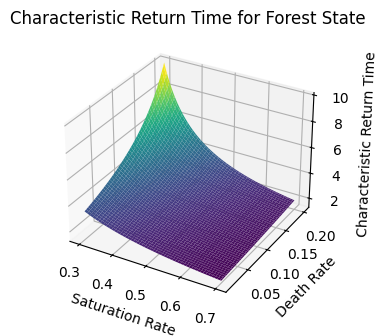

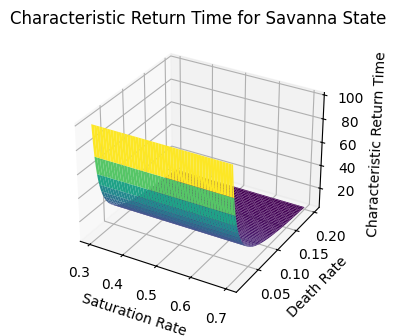

In [12]:
def plot_char_return_time(equilibrium, saturation_rate, die_rate):
    fig = plt.figure(figsize=(7,3.3))
    ax = fig.add_subplot(111, projection='3d')
    X, Y = np.meshgrid(saturation_rate, die_rate)
    Z = np.array([saturation_rate] * len(die_rate))
    
    for ri, r in enumerate(saturation_rate):
      for xi, x in enumerate(die_rate):
          Z[xi][ri] = char_return_time(equilibrium, r, x)
    ax.plot_surface(X, Y, Z, cmap='viridis')

    equilibrium_name = 'Forest State' if equilibrium == 'F' else 'Savanna State'
    title=f'Characteristic Return Time for {equilibrium_name}'
    
    ax.set_xlabel('Saturation Rate')
    ax.set_ylabel('Death Rate')
    ax.set_zlabel('Characteristic Return Time')
    ax.set_title(title)
    plt.tight_layout()
    plt.show()
    
plot_char_return_time('F', saturation_rate=list(np.linspace(0.3,0.7,100)), die_rate=list(np.linspace(0.01,0.2,100)))
plot_char_return_time('S', saturation_rate=list(np.linspace(0.3,0.7,100)), die_rate=list(np.linspace(0.01,0.2,100)))

# Global Return Time

Return time in the sense of the number of steps it takes to reach an equilibrium after a perturbation (different initial setting)

In [13]:
def return_time(initial_cover, aridity, max_steps=1000, eps=1e-6):
  cover = initial_cover
  steps = 0
  while steps < max_steps:
    if cover <= c_crit(aridity):
        return 0, -10
    
    if abs(cover - forest_state()) <= eps:
        return forest_state(), steps
    
    else: 
        cover = next_step(cover, aridity)
        steps += 1
  
  if steps == max_steps:
    return None, float('inf')
  
  return cover, steps

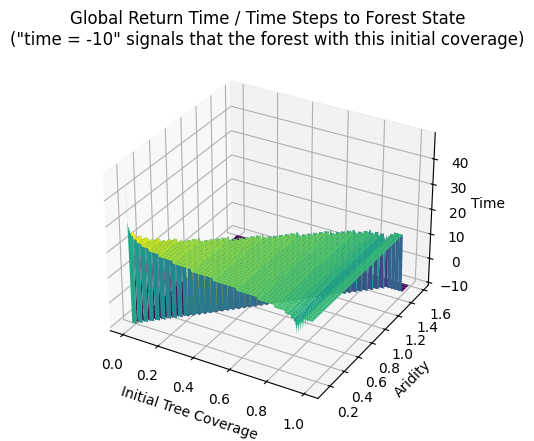

In [14]:
def plot_return_time(aridities, initial_values, eps=1e-6):

  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  X, Y = np.meshgrid(initial_values, aridities)
  Z = np.array([initial_values] * len(aridities))
  
  for ai, a in enumerate(aridities):
    for di, d in enumerate(initial_values):
      Z[ai][di] = return_time(d, a, eps=eps)[1]

  ax.plot_surface(X, Y, Z, cmap='viridis')

  ax.set_xlabel('Initial Tree Coverage')
  ax.set_ylabel('Aridity')
  ax.set_zlabel('Time')
  ax.set_title('Global Return Time / Time Steps to Forest State\n("time = -10" signals that the forest with this initial coverage)')

  plt.show()

plot_return_time(aridities, list(np.linspace(1e-6,1,1000)))

# Basin Stability

 The probability that the system will return to equilibrium when subjected to random perturbations.

In [15]:
# Aridities to test for basin stability
aridities_basin = list(np.linspace(0.14, 1.57, 10))
time_steps = 100
basin_stabilities = []

print('Basin stability for aridity A')
for aridity in aridities_basin:
    initial_cover_range = np.random.uniform(low=0, high=1, size=1000)
    acceptable_solutions = 0
    for initial_cover in initial_cover_range:
        cover = k_steps(initial_cover, aridity, time_steps)
        if forest_state() - 1e-6 < cover[-1] < forest_state() + 1e-6:
            acceptable_solutions += 1
    basin_stability = acceptable_solutions / len(initial_cover_range)
    basin_stabilities.append(basin_stability)
    print(f' A={aridity:.2f} : {basin_stability}')

Basin stability for aridity A
 A=0.14 : 1.0
 A=0.30 : 0.883
 A=0.46 : 0.767
 A=0.62 : 0.66
 A=0.78 : 0.558
 A=0.93 : 0.442
 A=1.09 : 0.352
 A=1.25 : 0.205
 A=1.41 : 0.106
 A=1.57 : 0.0


=> Basin of attraction shrinks for growing aridity (something that is not see when looking at linear stability only!)

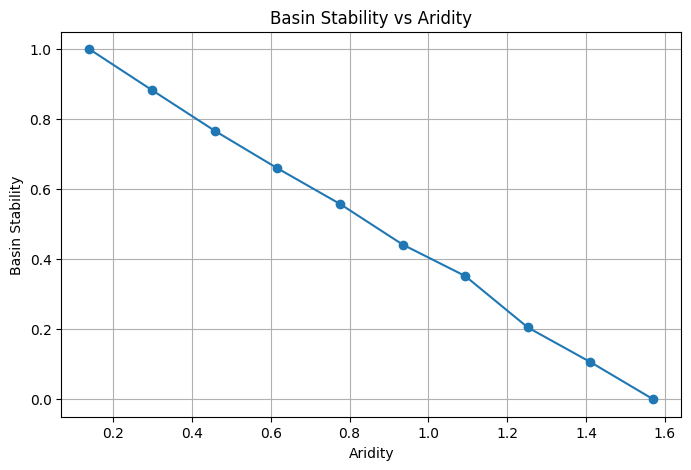

In [16]:
# Plot the results
plt.figure(figsize=(8, 5))
plt.plot(aridities_basin, basin_stabilities, marker='o')
plt.xlabel('Aridity')
plt.ylabel('Basin Stability')
plt.title('Basin Stability vs Aridity')
plt.grid(True)
plt.show()